In [178]:
import json
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import RectBivariateSpline, RegularGridInterpolator, CubicSpline
from hrosailing.polardiagram._reading import from_csv
from hrosailing.plotting import plot_polar

In [179]:
with open('data/Tracking_example_data_1.json', 'r') as file:
    data = json.load(file)

Layout of the data in the sample boat tracking information

In [180]:
print(data['schema'])
print(data['dframes'][0])

['_lat', '_lon', 'cog', 'sog', 'heading', 'pitch', 'roll', 'wspeed', 'wangle', 'twspeed', 'twangle', 'twdirection', 'vmg']
[-41.285089169939866, 174.79663346037051, 72.2, 5.6, 69.9, 2.6, 2.9, 22.08, -67.2, 18.57, -86.2, 345.4, 0.37]


For a very basic performance analysis twspeed, twangle, vmg are required

In [181]:
minimum_properties = ['sog', 'twspeed', 'twangle']
indices = [data['schema'].index(property) for property in minimum_properties]
filtered_dframes = [[row[i] for i in indices] for row in data['dframes']]
basic_analysis_data = {
    "schema": minimum_properties,
    "dframes": filtered_dframes
}

In [182]:
print(basic_analysis_data['schema'])
print(basic_analysis_data['dframes'][0])

['sog', 'twspeed', 'twangle']
[5.6, 18.57, -86.2]


Now, add the specific boat type ORC certified polars (a csv file from https://jieter.github.io/orc-data/site/index.html#AUS/7183)

In [183]:
polars_df = pd.read_csv('data/J112E_polars.csv', delimiter=';')
print(polars_df)

   twa/tws     6     8    10    12    14    16     20     24
0        0  0.00  0.00  0.00  0.00  0.00  0.00   0.00   0.00
1       52  5.58  6.58  7.14  7.38  7.50  7.56   7.63   7.62
2       60  5.87  6.82  7.32  7.57  7.70  7.78   7.88   7.87
3       75  6.07  6.97  7.45  7.76  7.98  8.13   8.31   8.40
4       90  6.02  7.07  7.50  7.80  8.10  8.36   8.74   8.98
5      110  6.15  7.24  7.79  8.18  8.45  8.69   9.15   9.58
6      120  6.02  7.16  7.77  8.26  8.69  9.08   9.75  10.44
7      135  5.42  6.70  7.48  8.01  8.53  9.10  10.56  12.60
8      150  4.59  5.79  6.78  7.44  7.83  8.19   8.98  11.51


Interpolate or smooth the polar values. It seems like bilinear interpolation (2D grid) would be most suited in this instance as we want to interpolate both across TWA and TWS at the same time.

Note. Notice the 0 values in the polars. These should be accounted for before performing interpolation as they should be excluded from the interpolation

In [184]:
polars_df.replace(0, np.nan, inplace=True)
polars_df.dropna(how='all', inplace=True)

Now it is possible to setup this data for the interpolation

Setup the 2D grid

In [185]:
# Set up TWA and TWS for the grid and extract boat speed data
twa = polars_df.columns[1:].astype(float).values
tws = polars_df.iloc[1:, 0].astype(float).values
boat_speeds = polars_df.iloc[1:, 1:].values.astype(float)
boat_speeds[np.isnan(boat_speeds)] = np.nanmean(boat_speeds)

# Ensure TWA and TWS are strictly increasing
twa, unique_twa_indices = np.unique(twa, return_index=True)
tws, unique_tws_indices = np.unique(tws, return_index=True)
boat_speeds = boat_speeds[np.ix_(unique_tws_indices, unique_twa_indices)]

In [186]:
# Set up RectBivariateSpline for interpolation
spline = RectBivariateSpline(tws, twa, boat_speeds)
# Interpolate for each TWS and TWA pair in basic analysis data
basic_tws = [row[0] for row in basic_analysis_data['dframes']]
basic_twa = [row[1] for row in basic_analysis_data['dframes']]
interpolated_speeds = spline.ev(basic_tws, basic_twa)

In [187]:
# Add the interpolated speeds to the basic analysis data
for i, row in enumerate(basic_analysis_data['dframes']):
    row.append(interpolated_speeds[i])
basic_analysis_data['schema'].append('interpolated_speed')

# Create a fine grid for a full interpolated speed display
twa_fine = np.linspace(np.min(twa), np.max(twa), 50)
tws_fine = np.linspace(np.min(tws), np.max(tws), 50)
TWA_grid, TWS_grid = np.meshgrid(twa_fine, tws_fine)

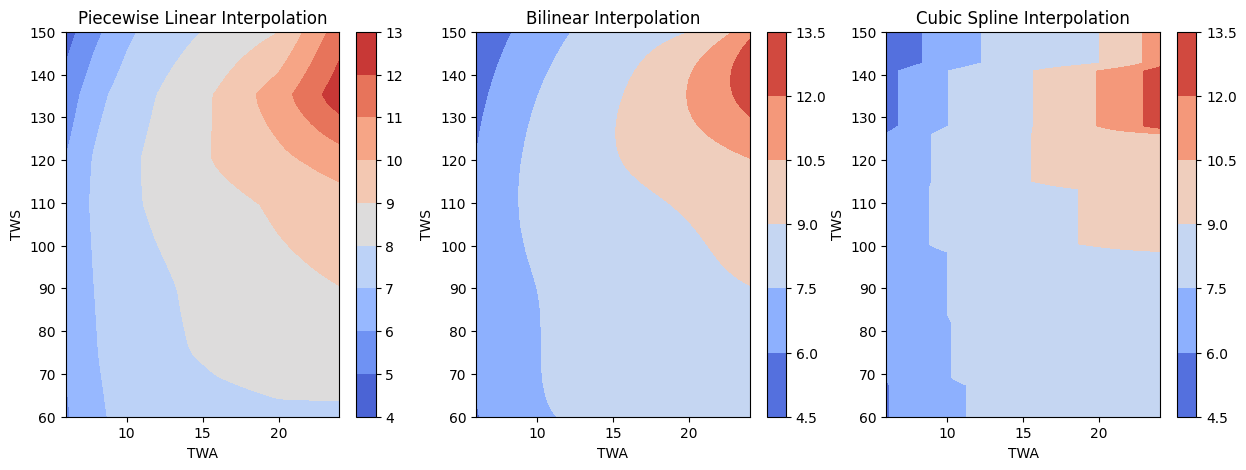

In [188]:
# Define RegularGridInterpolator
pl_interpolator = RegularGridInterpolator((tws, twa), boat_speeds, method='linear')
bi_interpolator = RectBivariateSpline(tws, twa, boat_speeds)

# Generate interpolated data
pl_speeds = pl_interpolator((TWS_grid, TWA_grid))
bi_speeds = bi_interpolator(tws_fine, twa_fine)

# Apply cubic spline interpolation row-wise
cubic_speeds = np.full((len(tws_fine), len(twa_fine)), np.nan)
for i, tws_value in enumerate(tws_fine):
    closest_tws_idx = np.argmin(np.abs(tws - tws_value))
    valid_twa = twa[~np.isnan(boat_speeds[closest_tws_idx, :])]
    valid_speeds = boat_speeds[closest_tws_idx, ~np.isnan(boat_speeds[closest_tws_idx, :])]
    if len(valid_twa) > 3:
        cubic_interpolator = CubicSpline(valid_twa, valid_speeds, extrapolate=False)
        cubic_speeds[i, :] = cubic_interpolator(twa_fine)

# Replace remaining NaNs only where necessary
cubic_speeds = np.where(np.isnan(cubic_speeds), np.nanmean(boat_speeds), cubic_speeds)


# Export interpolated grids to CSV
pl_df = pd.DataFrame(pl_speeds, index=tws_fine, columns=twa_fine)
bi_df = pd.DataFrame(bi_speeds, index=tws_fine, columns=twa_fine)
cubic_df = pd.DataFrame(cubic_speeds, index=tws_fine, columns=twa_fine)
pl_df.to_csv("data/piecewise_linear_interpolation.csv", sep=';')
bi_df.to_csv("data/bilinear_interpolation.csv", sep=';')
cubic_df.to_csv("data/cubic_interpolation.csv", sep=';')


# Plot results for each interpolation method
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.contourf(twa_fine, tws_fine, pl_speeds, cmap='coolwarm')
plt.title("Piecewise Linear Interpolation")
plt.xlabel("TWA")
plt.ylabel("TWS")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.contourf(twa_fine, tws_fine, bi_speeds, cmap='coolwarm')
plt.title("Bilinear Interpolation")
plt.xlabel("TWA")
plt.ylabel("TWS")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.contourf(twa_fine, tws_fine, cubic_speeds, cmap='coolwarm')
plt.title("Cubic Spline Interpolation")
plt.xlabel("TWA")
plt.ylabel("TWS")
plt.colorbar()
plt.show()

plt.show()


Found a library that can read the ORC polars format directly. Will test this out.

hrosailing - https://hrosailing.github.io/hrosailing/hrosailing.html#version-0-1-0


In [189]:
original = from_csv("data/J112E_polars.csv", fmt="orc")
pl = from_csv("data/piecewise_linear_interpolation.csv", fmt="orc")
bi = from_csv("data/bilinear_interpolation.csv", fmt="orc")
cubic = from_csv("data/cubic_interpolation.csv", fmt="orc")

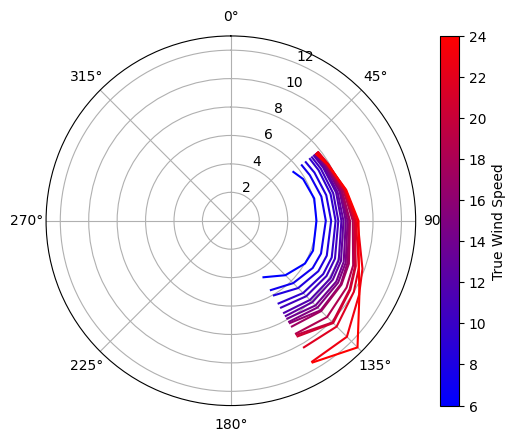

In [190]:
plot_polar(original, ws=[6, 24], n_steps=15, colors=('blue', 'red'), show_legend=True)

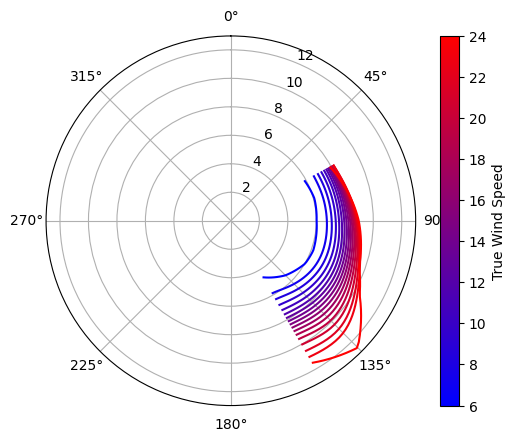

In [191]:
plot_polar(pl, ws=[6, 24], n_steps=15, colors=('blue', 'red'), show_legend=True)

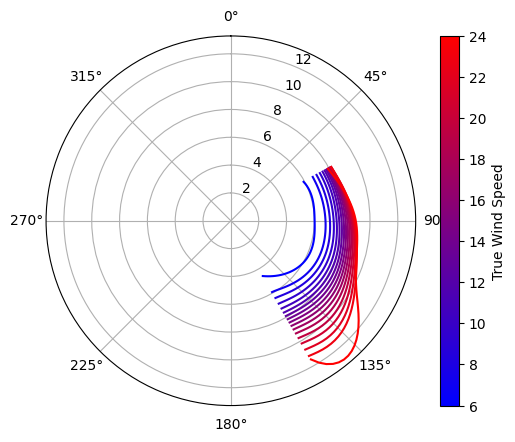

In [192]:
plot_polar(bi, ws=[6, 24], n_steps=15, colors=('blue', 'red'), show_legend=True)

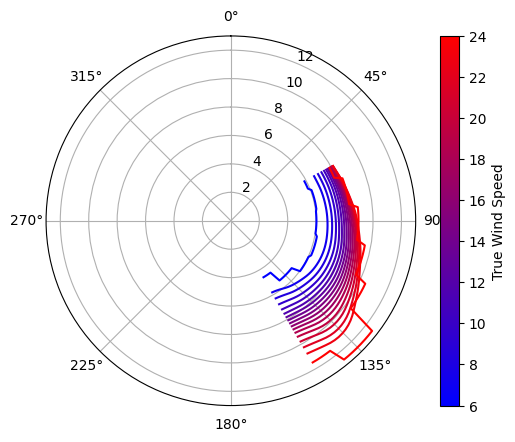

In [193]:
plot_polar(cubic, ws=[6, 24], n_steps=15, colors=('blue', 'red'), show_legend=True)

We try to plot the measured and interpolated data

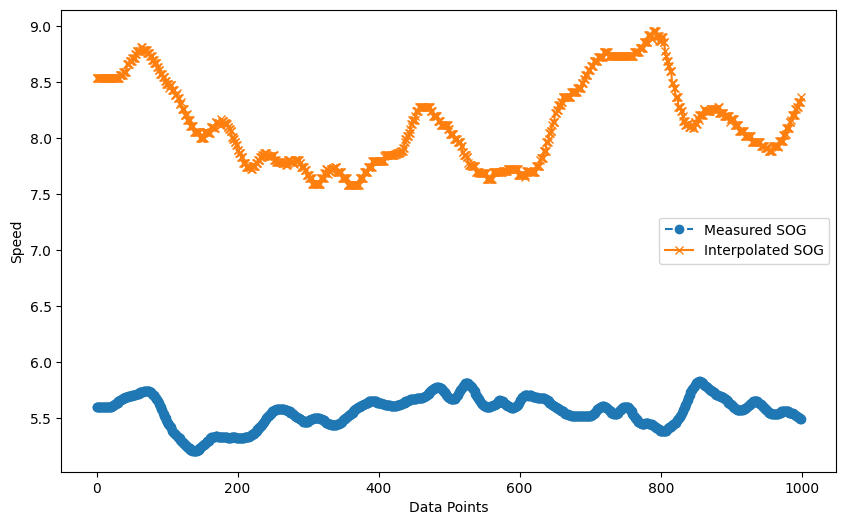

In [194]:
# Extract the first 100 points from the measured dataset for clarity
measured_data_subset = basic_analysis_data['dframes'][:1000]

# Prepare lists to store the matched SOG values for plotting
measured_sogs = []
interpolated_sogs = []

# Loop through each entry in the measured dataset
for measured_entry in measured_data_subset:
    measured_sog, measured_tws, measured_twa = measured_entry[:3]  # Extract measured SOG, TWS, TWA
    measured_twa = abs(measured_twa)  # Take the absolute value of TWA for matching

    # Now that TWA and TWS are correctly oriented in df_grid, match accordingly
    closest_twa = min(bi_df.index, key=lambda x: abs(x - measured_twa))  # TWA in rows (index)
    closest_tws = min(bi_df.columns, key=lambda x: abs(x - measured_tws))  # TWS in columns

    # Retrieve the interpolated SOG from the grid using the closest TWA and TWS
    interpolated_sog = bi_df.loc[closest_twa, closest_tws]
    
    # Append the measured and interpolated SOGs for plotting
    measured_sogs.append(measured_sog)
    interpolated_sogs.append(interpolated_sog)

# Plot the comparison between measured and interpolated SOGs
plt.figure(figsize=(10, 6))
plt.plot(measured_sogs, label='Measured SOG', linestyle='--', marker='o')
plt.plot(interpolated_sogs, label='Interpolated SOG', linestyle='-', marker='x')

plt.xlabel('Data Points')
plt.ylabel('Speed')
plt.legend()
plt.show()